In [78]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd

# plot
%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Load Data

  * Original decision was to store the data straight to disk as flat text files.
  * This lower the load on the pi, so lets grab the right columns, and build up a large ~200MB dataframe

In [112]:
filenamepattern = '/Users/ajmendez/flight/locations_*.log'
data = None
for filename in glob.glob(filenamepattern):
    tmp = pd.read_csv(filename, skiprows=1, usecols=[4,6,7,11,14,15], 
                     names='flight date time alt lat lon'.split())
    if data is None:
        data = tmp
        break
    else:
        data =  pd.concat([data, tmp])

# Create Tags

  * datenum -- the number of days since the start
  * distance -- distance away from detector
  * heading -- angle from north for plane

In [116]:
tmp.shape

(171697,)

In [117]:
tmp = (data['date']+' '+data['time']).apply(parser.parse)
# data['datenum'] = date2num(tmp.apply(parser.parse))
# data['datenum'] -= data['datenum'].min()

In [109]:
ant = LatLon.LatLon(39.331832, -76.623450)
def get_heading_distance(tmp):
    heading = np.zeros(len(tmp))
    distance = np.zeros(len(tmp))
    for i in tmp.index:
        try:
            loc = LatLon.LatLon(tmp['lat'][i],tmp['lon'][i])
        except Exception as e:
            print i, tmp['lat'][i],tmp['lon'][i]
            raise
        heading[i] = ant.heading_initial(loc)
        distance[i] = ant.distance(loc)
    return heading, distance

get_heading_distance(data[['lat', 'lon']][100:])

100 100    39.17683
100    40.53268
100    39.10565
100    39.96458
100    40.71021
100    40.25898
100    39.48477
100    40.54633
100    40.00955
100    39.78085
100    39.36182
100    40.69206
100    39.34602
100    40.44228
100    40.16281
100    39.63453
100    40.03555
100    39.35431
100    39.93137
100    39.42746
100    39.30447
100    39.07993
100    39.99930
100    40.36487
100    39.67790
100    39.43128
100    40.14800
100    39.20778
100    39.55522
100    39.42681
Name: lat, dtype: float64 100   -77.31085
100   -76.62775
100   -77.89802
100   -76.51378
100   -76.71814
100   -76.75848
100   -77.69663
100   -76.73254
100   -76.61493
100   -77.80691
100   -76.76595
100   -76.66285
100   -76.97708
100   -76.44012
100   -76.52722
100   -76.61157
100   -76.66571
100   -76.66176
100   -77.15894
100   -77.47614
100   -77.03735
100   -77.49911
100   -76.54559
100   -76.72083
100   -77.23777
100   -77.26538
100   -76.46091
100   -76.89819
100   -76.86340
100   -77.11963
Name: lon,

TypeError: cannot convert the series to <type 'float'>

(array([-105.90896683, -105.80561342, -105.76353523, -105.56450346,
        -105.5169061 , -105.43126897, -105.23798443, -104.97972355,
        -104.94386766, -104.80871475]),
 array([ 82.03715178,  81.91059454,  81.86320048,  81.61928354,
         81.56189914,  81.45127981,  81.19058509,  80.80701857,
         80.75258897,  80.53230159]))

# Clean Data

  * There are a bunch of very odd records, so clean by removing anything far far away.
  * Some of these are due to being able to "observe" planes close to the airport so that their GPS signal is quite bad.
  * 

KeyboardInterrupt: 

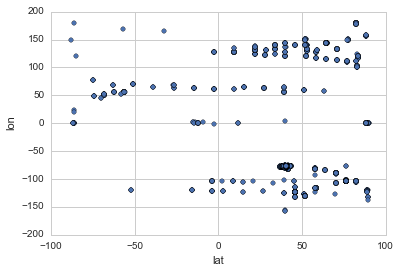

In [72]:

data.plot('lat', 'lon', 'scatter')

In [ ]:
# save it as a db for other things.
# db = dataset.connect('sqlite:///Users/ajmendez/flight.db')
engine = create_engine('sqlite:////Users/ajmendez/flight.db')
if not database_exists(engine.url):
    create_database(engine.url)

with engine.connect() as conn, conn.begin():
    data.to_sql('data', engine)
